In [108]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm

from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots as gpl

# Загрузка данных

In [6]:
moex = pd.read_csv('../Our_super_project/risk_factors/IMOEX.ME.csv')
oil = pd.read_csv('../Our_super_project/risk_factors/BZ=F.csv')

In [26]:
moex.Date = pd.to_datetime(moex.Date)
oil.Date = pd.to_datetime(oil.Date)

risk_factors = moex[['Date', 'Adj Close']].merge(oil[['Date', 'Adj Close']], on='Date', how='inner')

In [31]:
risk_factors.rename(columns={'Adj Close_x': 'moex', 'Adj Close_y': 'oil'}, inplace=True)
print(risk_factors.shape)
risk_factors.set_index('Date', inplace=True)
risk_factors.head()

(952, 3)


,moex,oil
Date,,
2017-01-03,2285.429932,55.470001
2017-01-04,2263.899902,56.459999
2017-01-05,2220.350098,56.889999
2017-01-06,2213.929932,57.099998
2017-01-09,2211.250000,54.939999


### Анализ риск-факторов

In [139]:
def plot_cor_matrix(risk_factors: pd.DataFrame) -> None:
    corr_matrix = risk_factors.corr()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    
    sns.heatmap(corr_matrix, annot=True)
    
    plt.show()

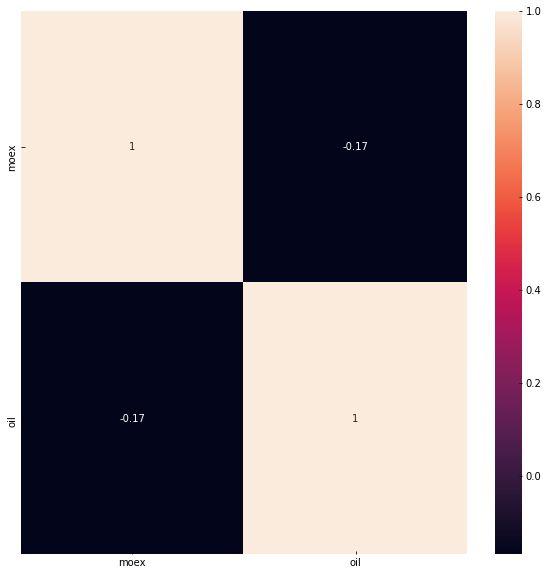

In [140]:
plot_cor_matrix(risk_factors)

In [141]:
def risk_factor_describe(risk_factor: pd.Series) -> None:
    risk_factor_name = risk_factor.name
    print(f"{'=' * 10} {risk_factor_name.upper()} {'=' * 10}")
    print(f"mean: {np.round(np.mean(risk_factor), 2)}")
    print(f"std: {np.round(np.std(risk_factor), 2)}")
    print(f"min: {np.round(np.min(risk_factor), 2)}")
    print(f"max: {np.round(np.max(risk_factor), 2)}")
    adfuller_pv = adfuller(risk_factor)[1]
    print(
        f"The Augmented Dickey-Fuller test, p-value: {adfuller_pv}, "
        f"series is {'non' if adfuller_pv >= 0.05 else ''} stationary"
    )
    risk_factor_change = risk_factor.pct_change().iloc[1:]
    adfuller_pv = adfuller(risk_factor_change)[1]
    print(
        f"The Augmented Dickey-Fuller test for pct change, p-value: {adfuller_pv}, "
        f"series is {'non' if adfuller_pv >= 0.05 else ''} stationary"
    )
    
    fig = plt.figure(figsize=(15, 15))
    
    ax = plt.subplot(511)
    sns.lineplot(x=risk_factor.index, y=risk_factor, ax=ax)
    plt.title('Price')
    
    ax = plt.subplot(512)
    sns.lineplot(x=risk_factor_change.index, y=risk_factor_change, ax=ax)
    plt.title('Price percent change')
    
    ax = plt.subplot(525)
    spl.plot_acf(risk_factor, lags=20, ax=ax)
    
    ax = plt.subplot(526)
    spl.plot_pacf(risk_factor, lags=20, ax=ax)
    
    ax = plt.subplot(527)
    normal_dist = gpl.ProbPlot(risk_factor, fit=True)
    normal_dist.qqplot(line='r', ax=ax)
    plt.title('Q-Q')
    
    ax = plt.subplot(528)
    normal_dist.ppplot(line='45', ax=ax)
    plt.title('P-P')
    
    ax = plt.subplot(529)
    normal_dist.probplot(line='r', ax=ax)
    plt.title('Prob')
    
    ax = plt.subplot(5, 2, 10)
    sns.distplot(risk_factor, ax=ax)
    plt.title('Distribution')
    
    plt.tight_layout()
    plt.show()

========== MOEX ==========
mean: 2478.39
std: 359.03
min: 1817.82
max: 3289.02
The Augmented Dickey-Fuller test, p-value: 0.918150195982425, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.5803937148259294e-09, series is  stationary


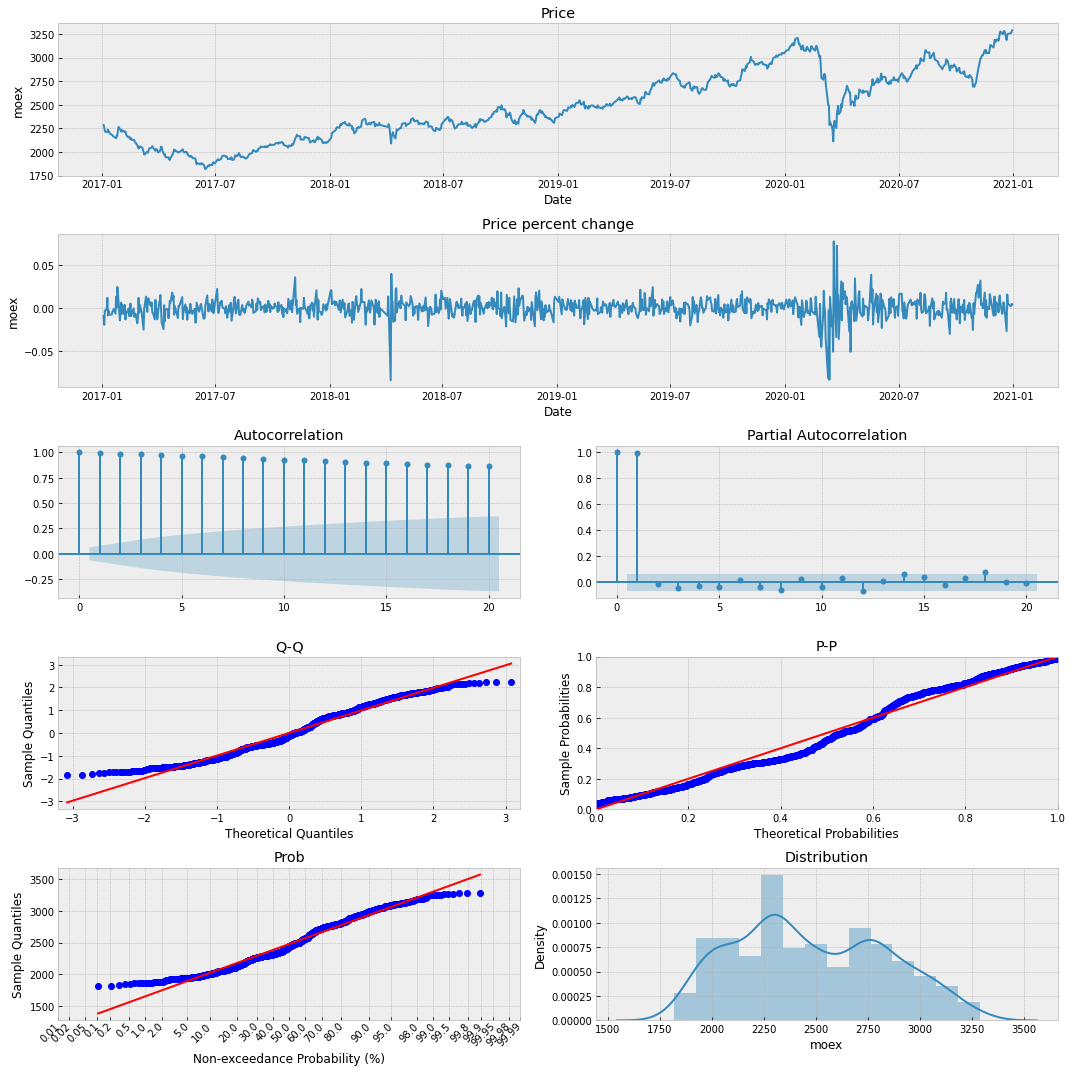

In [142]:
risk_factor_describe(risk_factors.moex)

========== OIL ==========
mean: 58.38
std: 12.84
min: 19.33
max: 86.29
The Augmented Dickey-Fuller test, p-value: 0.3019781330723652, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 2.443383967371305e-07, series is  stationary


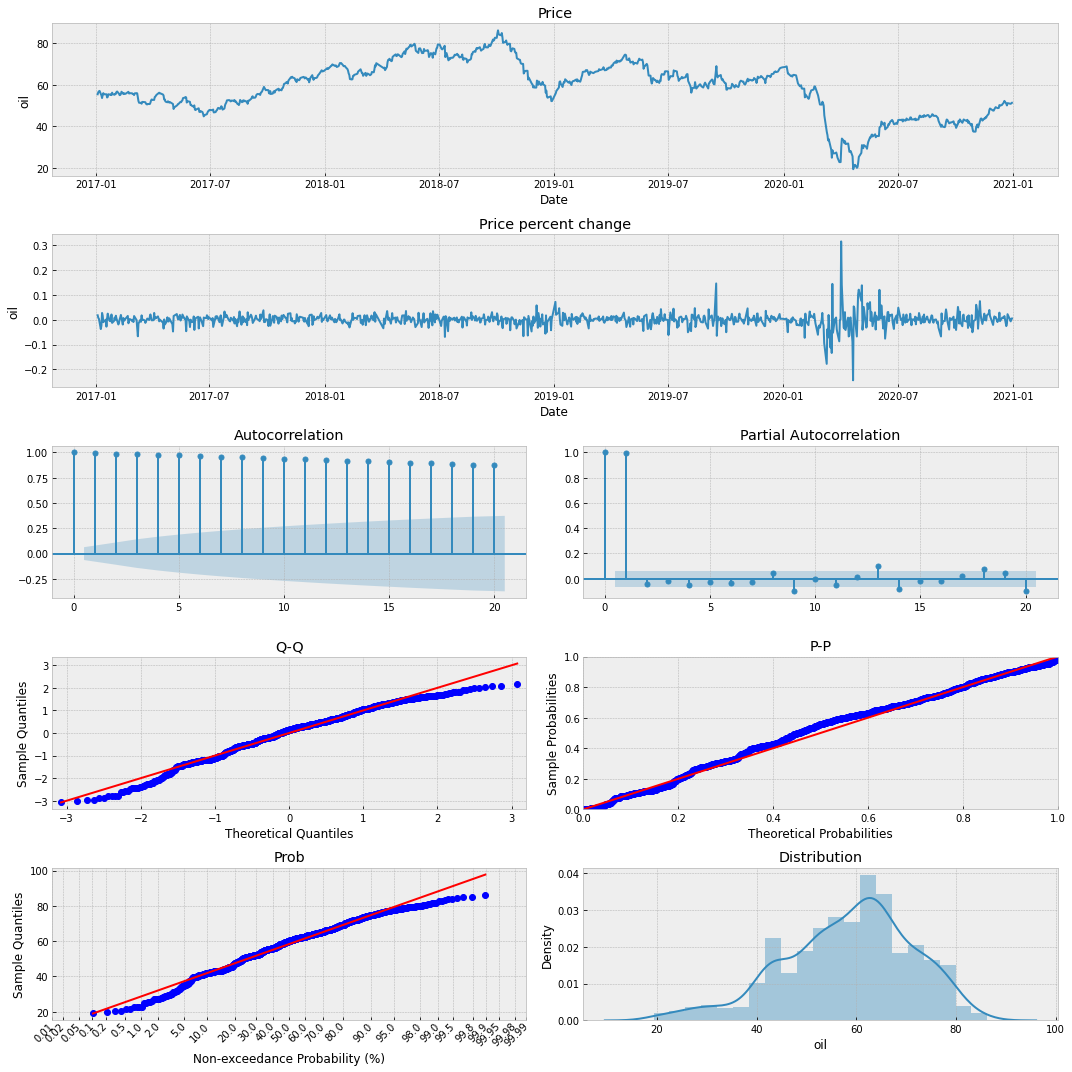

In [143]:
risk_factor_describe(risk_factors.oil)